In [3]:
import sys
print(sys.version)

3.10.19 (main, Oct 21 2025, 16:43:05) [GCC 11.2.0]


In [4]:
# Standard Library
import os
import sys
import json
import math
import random 
from pathlib import Path
from typing import List, Optional, Tuple, Union
from collections import defaultdict

# Data Science & Utilities
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# DeepChem
import deepchem
from deepchem.molnet import *

# RDKit
from rdkit import Chem

# Torch
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn import CrossEntropyLoss, MSELoss, BCEWithLogitsLoss
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast

# Accelerate
from accelerate import Accelerator

# Transformers
from transformers import (
    AutoModel, AutoModelForMaskedLM, AutoModelForSequenceClassification,
    AutoTokenizer, RobertaModel, RobertaTokenizer, RobertaTokenizerFast,
    RobertaConfig, RobertaPreTrainedModel, DebertaV2Model, DebertaV2Config,
    DebertaTokenizerFast, LongformerModel, LongformerConfig,
    LongformerForMaskedLM, LongformerTokenizerFast,
    AutoConfig, Trainer, TrainingArguments, pipeline,
    default_data_collator
)
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.trainer_pt_utils import get_parameter_names

# Tokenizers
from tokenizers import ByteLevelBPETokenizer
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

# ESM
import esm

# Datasets
from datasets import Dataset, DatasetDict, load_from_disk

# Metrics
import sklearn
from sklearn.metrics import ( 
    root_mean_squared_error, mean_squared_error, roc_auc_score, mean_absolute_error
)

# Bitsandbytes
import bitsandbytes as bnb

# Misc
import ipynbname


# Dataset Loading (if exists)

In [5]:
def get_notebook_name():
    try:
        return ipynbname.name()
    except Exception:
        return "unknown_notebook"

# Get the notebook's name
notebook_name = get_notebook_name().split(".")[0]  # Remove file extension if any
os.makedirs("result_graphs", exist_ok=True)

In [6]:
#model_pth = "/Documents/GitHub/CheMLT-F/Pre-Training"
model_pth = "./GrandBookData/PubchemModelDeberta"
#model_pth2 = "./GrandBookData/ProteinModelDeb"

In [7]:
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import DebertaTokenizerFast

save_dir = "Datasets"

# 🔧 Per-dataset config: path, split, columns, etc.
Datasets_Available = {
    "egc": {
        "csv_path": "./Datasets/EGC/standardized_egc_data_tp.csv",
        "test_size": 0.20,   # 85/15 split
        "input_column": "canonical_smiles",
        "label_column": "value",
        "subdir": "EGC"
    },
    "ri":{
        "csv_path": "./Datasets/RI/standardized_nc_data_tp.csv",
        "test_size": 0.20,   # 85/15 split
        "input_column": "canonical_smiles",
        "label_column": "value",
        "subdir": "RI"
    },
    "dk": {
        "csv_path": "./Datasets/DK/standardized_eps_data_tp.csv",
        "test_size": 0.20,   # 85/15 split
        "input_column": "canonical_smiles",
        "label_column": "value",
        "subdir": "DK"
    },
    "tg": {
        "csv_path": "./Datasets/TG/canonicalized_pi_normalized.csv",
        "test_size": 0.20,   # 85/15 split
        "input_column": "canonical_smiles",
        "label_column": "value",
        "subdir": "TG"
    },
    "density": {
        "csv_path": "./Datasets/Density/standardized_Den_373_data.csv",
        "test_size": 0.20,   # 85/15 split
        "input_column": "canonical_smiles",
        "label_column": "value",
        "subdir": "Density"
    },
}

model_pth = "./GrandBookData/PubchemModelDeberta"
tokenizer = DebertaTokenizerFast.from_pretrained(model_pth)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DebertaV2TokenizerFast'. 
The class this function is called from is 'DebertaTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DebertaV2TokenizerFast'. 
The class this function is called from is 'DebertaTokenizerFast'.


In [8]:
# -ORIGINAL --- 
def prepare_single_dataset(name, cfg):
    """
    name: task name, e.g. "egc"
    cfg: config dict for that dataset
    returns: (train_tokenized, test_tokenized)
    """
    csv_path     = cfg["csv_path"]
    test_size    = cfg["test_size"]
    input_col    = cfg["input_column"]
    label_col    = cfg["label_column"]
    subdir       = cfg["subdir"]

    inputdata_dir = os.path.join(save_dir, subdir)
    os.makedirs(inputdata_dir, exist_ok=True)

    train_datasets_path = os.path.join(inputdata_dir, "train_datasets")
    test_datasets_path  = os.path.join(inputdata_dir, "test_datasets")

    # ==== LOAD CSV ====
    df = pd.read_csv(csv_path)

    # ==== TRAIN/TEST SPLIT with specific ratio ====
    train_df, test_df = train_test_split(
        df,
        test_size=test_size,
        random_state=42,
        shuffle=True,
    )

    # ==== Build HF datasets ====
    train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
    test_ds  = Dataset.from_pandas(test_df.reset_index(drop=True))

    # Make sure label column is called "labels" for the trainer
    if "labels" not in train_ds.column_names:
        train_ds = train_ds.rename_column(label_col, "labels")
        test_ds  = test_ds.rename_column(label_col, "labels")

    # ==== Tokenization ====
    def tokenize_batch(batch):
        enc = tokenizer(
            batch[input_col],
            padding="max_length",
            truncation=True,
            max_length=256,
        )
        enc["labels"] = [float(x) for x in batch["labels"]]
        return enc

    train_tokenized = train_ds.map(
        tokenize_batch,
        batched=True,
        remove_columns=train_ds.column_names,
    )
    test_tokenized = test_ds.map(
        tokenize_batch,
        batched=True,
        remove_columns=test_ds.column_names,
    )

    train_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    test_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    # (Optional) save raw HF datasets (pre-tokenization) if you want
    train_ds.save_to_disk(train_datasets_path)
    test_ds.save_to_disk(test_datasets_path)

    print(f"[{name}] Loaded {len(df)} rows, split into {train_tokenized.num_rows} train / {test_tokenized.num_rows} test")

    return train_tokenized, test_tokenized


In [9]:

# Final structure for multitask trainer
updated_datasets = {
    "train": {},
    "test": {}
}

for task_name, cfg in Datasets_Available.items():
    train_tok, test_tok = prepare_single_dataset(task_name, cfg)
    updated_datasets["train"][task_name] = train_tok
    updated_datasets["test"][task_name]  = test_tok

datasets_exist = True
print("All datasets loaded, split, tokenized, and registered in updated_datasets.")

# (Optional) quick check
for split, dct in updated_datasets.items():
    print(f"Split: {split}")
    for task_name, ds in dct.items():
        print(f"  {task_name}: {ds.num_rows} samples")


Map: 100%|██████████████████████████| 724/724 [00:00<00:00, 15031.12 examples/s]
Saving the dataset (1/1 shards): 100%|█| 2892/2892 [00:00<00:00, 1229467.58 exam
Saving the dataset (1/1 shards): 100%|█| 724/724 [00:00<00:00, 530053.43 example


[egc] Loaded 3616 rows, split into 2892 train / 724 test


Map: 100%|████████████████████████████| 84/84 [00:00<00:00, 10416.01 examples/s]
Saving the dataset (1/1 shards): 100%|█| 333/333 [00:00<00:00, 223401.03 example
Saving the dataset (1/1 shards): 100%|█| 84/84 [00:00<00:00, 59928.82 examples/s


[ri] Loaded 417 rows, split into 333 train / 84 test


Map: 100%|████████████████████████████| 83/83 [00:00<00:00, 10849.82 examples/s]
Saving the dataset (1/1 shards): 100%|█| 330/330 [00:00<00:00, 198241.24 example
Saving the dataset (1/1 shards): 100%|█| 83/83 [00:00<00:00, 56258.44 examples/s


[dk] Loaded 413 rows, split into 330 train / 83 test


Map: 100%|██████████████████████████| 277/277 [00:00<00:00, 13599.54 examples/s]
Saving the dataset (1/1 shards): 100%|█| 1104/1104 [00:00<00:00, 130580.40 examp
Saving the dataset (1/1 shards): 100%|█| 277/277 [00:00<00:00, 165031.56 example


[tg] Loaded 1381 rows, split into 1104 train / 277 test


Map: 100%|████████████████████████████| 75/75 [00:00<00:00, 10066.01 examples/s]
Saving the dataset (1/1 shards): 100%|█| 298/298 [00:00<00:00, 201337.40 example
Saving the dataset (1/1 shards): 100%|█| 75/75 [00:00<00:00, 55411.80 examples/s

[density] Loaded 373 rows, split into 298 train / 75 test
All datasets loaded, split, tokenized, and registered in updated_datasets.
Split: train
  egc: 2892 samples
  ri: 333 samples
  dk: 330 samples
  tg: 1104 samples
  density: 298 samples
Split: test
  egc: 724 samples
  ri: 84 samples
  dk: 83 samples
  tg: 277 samples
  density: 75 samples


# Training

In [10]:
# --- Original model ------------------------------------

class MLTClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""
    def __init__(self, config, num_labels):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size//2)
        classifier_dropout = config.hidden_dropout_prob
        self.dropout = nn.Dropout(classifier_dropout)
        self.out_proj = nn.Linear(config.hidden_size//2, num_labels)

    def forward(self, features, **kwargs):
        x = self.dropout(features)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class RobertaMultiTaskModel(RobertaPreTrainedModel):
    def __init__(self, model_path1, model_path2, num_labels_list, problem_type_list):
        """
        Args:
        - config: Model configuration.
        - num_labels_list: A list where each element represents the number of labels for a specific task.
        """
        self.model_path1 = model_path1
        self.model_path2 = model_path2
        config = AutoConfig.from_pretrained(model_path1)
        super().__init__(config)
        self.config = config
        #self.config2 = AutoConfig.from_pretrained(model_path2)
        #print(self.config.hidden_size, self.config2.hidden_size )
        # Two separate encoders
        self.encoder1 = DebertaV2Model.from_pretrained(model_path1)
        #self.encoder2 = DebertaV2Model.from_pretrained(model_path2)
        for param in self.encoder1.parameters():
            param.requires_grad = False
        for layer in self.encoder1.encoder.layer[4:]:  # Freeze first 6 layers (for 12-layer transformers)
            for param in layer.parameters():
                param.requires_grad = True

        self.encoder2 = None
        if self.model_path2 is not None:
            self.config2 = AutoConfig.from_pretrained(model_path2)
            self.encoder2 = DebertaV2Model.from_pretrained(model_path2)

            # Freeze parts of encoder2
            for param in self.encoder2.parameters():
                param.requires_grad = False
            for layer in self.encoder2.encoder.layer[4:]:
                for param in layer.parameters():
                    param.requires_grad = True
        '''
        for param in self.encoder2.parameters():
            param.requires_grad = False
        for layer in self.encoder2.encoder.layer[4:]:  # Freeze first 6 layers (for 12-layer transformers)
            for param in layer.parameters():
                param.requires_grad = True
        '''
        
        self.dense = nn.Linear((config.hidden_size)*3, config.hidden_size)
        classifier_dropout = config.hidden_dropout_prob
        
        self.dropout = nn.Dropout(classifier_dropout)
        # Task-specific classification heads
        self.hidden_size = config.hidden_size
        self.num_tasks = len(num_labels_list)
        self.classification_heads = nn.ModuleList(
            [MLTClassificationHead(config, num_labels=num_labels) 
             for num_labels in num_labels_list]
        )

        # Number of labels for each task
        self.num_labels_list = num_labels_list
        self.problem_type_list = problem_type_list
        # Initialize weights
        self.post_init()

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        input_ids2: Optional[torch.LongTensor] = None,
        attention_mask2: Optional[torch.FloatTensor] = None,
        input_ids3: Optional[torch.LongTensor] = None,
        attention_mask3: Optional[torch.FloatTensor] = None,
        labels_list: Optional[list] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        train:Optional[bool] = False,
        task_index:Optional[int] = 0,
    ) -> Union[Tuple[torch.Tensor], dict]:
        """
        Args:
        - input_ids1, attention_mask1: Inputs for the first encoder.
        - input_ids2, attention_mask2: Inputs for the second encoder.
        - labels_list: List of labels for each task.
        - return_dict: Whether to return a dictionary or a tuple.

        Returns:
        - A dictionary or tuple containing task-specific logits and optional losses.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # First encoder forward pass
        outputs1 = self.encoder1(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        pooled_output1 = outputs1.last_hidden_state[:, 0, :]  # [CLS] token

        #if input_ids2 is not None and attention_mask2 is not None:
        if (
            self.encoder2 is not None
            and input_ids2 is not None
            and attention_mask2 is not None
        ):

            outputs2 = self.encoder2(
                input_ids=input_ids2,
                attention_mask=attention_mask2,
                output_attentions=None,
                output_hidden_states=None,
                return_dict=return_dict,
            )
            outputs3 = self.encoder2(
                input_ids=input_ids3,
                attention_mask=attention_mask3,
                output_attentions=None,
                output_hidden_states=None,
                return_dict=return_dict,
            )
            pooled_output2 = outputs2.last_hidden_state[:, 0, :]  # [CLS] token
            pooled_output3 = outputs3.last_hidden_state[:, 0, :] 
            combined_output = torch.cat((pooled_output1, pooled_output2, pooled_output3), dim=1)
        else:
            combined_output= torch.cat((pooled_output1, torch.zeros_like(pooled_output1),torch.zeros_like(pooled_output1)), dim=1)
            # [CLS] token # Provide zeros if no input to encoder2

        combined_output = self.dropout(combined_output)
        combined_output = self.dense(combined_output)
        combined_output = F.gelu(combined_output)
        
        # Compute task-specific logits
        logits_list = self.classification_heads[task_index](combined_output)
        #logits_list = [head(combined_output) for head in self.classification_heads]

        # Return output
        if not return_dict:
            return logits_list if not losses else (sum(losses), logits_list)

        return {
            #"extra_loss" : combined_loss,
            "logits": logits_list,
        }


In [11]:
print(updated_datasets.keys())
for key in updated_datasets.keys():
    print(updated_datasets[key].keys())

dict_keys(['train', 'test'])
dict_keys(['egc', 'ri', 'dk', 'tg', 'density'])
dict_keys(['egc', 'ri', 'dk', 'tg', 'density'])


In [12]:

# #---EGC----
Datasets_Available["egc"] = {"problem_type": "regression", "num_labels": 1, "used_encoders" : "multiencoder"}

# #--- Refractive Index----
Datasets_Available["ri"] = {"problem_type": "regression", "num_labels": 1, "used_encoders" : "multiencoder"}

#---Dielectric Constant ---
Datasets_Available["dk"] = {"problem_type": "regression", "num_labels": 1, "used_encoders" : "multiencoder"}

#---Glass Transition temp---
Datasets_Available["tg"] = {"problem_type": "regression", "num_labels": 1, "used_encoders" : "multiencoder"}

#---Density---
Datasets_Available["density"] = {"problem_type": "regression", "num_labels": 1, "used_encoders" : "multiencoder"}

#Datasets_Available["kiba"] = {"problem_type": "regression", "num_labels": 1, "used_encoders" : "multiencoder"}

num_labels_list = [value["num_labels"] for value in Datasets_Available.values()]
problem_type_list = [value["problem_type"] for value in Datasets_Available.values()]
model = RobertaMultiTaskModel(model_pth, None, num_labels_list, problem_type_list)
for param in model.parameters():
    print(param.size(),param.requires_grad)

torch.Size([2692, 768]) False
torch.Size([512, 768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([3072, 768]) False
torch.Size([3072]) False
torch.Size([768, 3072]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([3072, 768]) False
torch.Size([3072]) False
torch.Size([768, 3072]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.

In [13]:
print("Dataset order:", list(updated_datasets["train"].keys()))
print("Head labels :", num_labels_list)
print("Head types  :", problem_type_list)

Dataset order: ['egc', 'ri', 'dk', 'tg', 'density']
Head labels : [1, 1, 1, 1, 1]
Head types  : ['regression', 'regression', 'regression', 'regression', 'regression']


In [14]:
model

RobertaMultiTaskModel(
  (encoder1): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(2692, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-5): 6 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, el

In [15]:
def get_optimizer(model, n):
    training_args = TrainingArguments(
        output_dir="./models/multitask_model" + n,
        overwrite_output_dir=True,
        learning_rate=5e-5,
        weight_decay=5e-3,
        do_train=True,
        num_train_epochs=40,
        fp16=True,
        per_device_train_batch_size=32,
        gradient_accumulation_steps=2,
    )
    #model = multitask_model.taskmodels_dict["tox21"]
    decay_parameters = get_parameter_names(model, [nn.LayerNorm])
    decay_parameters = [name for name in decay_parameters if "bias" not in name]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if n in decay_parameters],
            "weight_decay": training_args.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if n not in decay_parameters],
            "weight_decay": 0.0,
        },
    ]
    
    optimizer_kwargs = {
        "betas": (training_args.adam_beta1, training_args.adam_beta2),
        "eps": training_args.adam_epsilon,
    }
    optimizer_kwargs["lr"] = training_args.learning_rate
    adam_bnb_optim = bnb.optim.AdamW8bit(
        optimizer_grouped_parameters,
        betas=(training_args.adam_beta1, training_args.adam_beta2),
        eps=training_args.adam_epsilon,
        lr=training_args.learning_rate,
    )
    return adam_bnb_optim, training_args

optimizer,training_args = get_optimizer(model,notebook_name)


In [16]:
optimizer

AdamW8bit (
Parameter Group 0
    alpha: 0.0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 5e-05
    t_alpha: None
    t_beta3: None
    weight_decay: 0.005

Parameter Group 1
    alpha: 0.0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 5e-05
    t_alpha: None
    t_beta3: None
    weight_decay: 0.0
)

In [17]:
from transformers import get_scheduler
class MultiTaskWeightedTrainer:
    def __init__(
        self,
        model,
        datasets,
        ordered_tasks,
        optimizers: Tuple[Optional[torch.optim.Optimizer], Optional[torch.optim.lr_scheduler.LambdaLR]] = (None, None),
        args: TrainingArguments = None,
        **kwargs
    ):
        """
        Custom multitask trainer with Hugging Face `Accelerator` for mixed precision.
        """
        if args.fp16:
            precision="fp16"
        elif args.bf16:
            precision="bf16"
        else:
            precision="no"
        self.accelerator = Accelerator(mixed_precision=precision)
        self.model = self.accelerator.prepare(model)
        self.optimizer = self.accelerator.prepare(optimizers[0])

        self.batch_size = args.per_device_train_batch_size
        self.gradient_accumulation_steps = args.gradient_accumulation_steps
        self.data_collator = kwargs.get("data_collator", default_data_collator)

        self.ordered_tasks = ordered_tasks
        self.task_names = list(ordered_tasks.keys())

        # Prepare train & eval dataloaders
        self.train_dataloaders = self._prepare_dataloaders(datasets['train'], train=True)
        self.train_dataloaders2 = self._prepare_dataloaders(datasets['train'], train=False)
        self.eval_dataloaders = self._prepare_dataloaders(datasets['test'], train=False)
        
        # 4) Compute steps per epoch
        total_micro_steps = sum(len(dl) for dl in self.train_dataloaders.values())
        steps_per_epoch   = math.ceil(total_micro_steps / self.gradient_accumulation_steps)

        print("Total epochs:",args.num_train_epochs)
        
        # 5) Compute total steps across all epochs
        self.total_train_steps = steps_per_epoch * args.num_train_epochs
        print(total_micro_steps,self.total_train_steps)
        self.lr_scheduler = get_scheduler(
                name="linear",
                optimizer=self.optimizer,
                num_warmup_steps=self.total_train_steps//10,
                num_training_steps=self.total_train_steps,
            )
        
        # Compute task sampling probabilities
        task_sizes = {task: len(self.train_dataloaders[task]) for task in self.task_names}
        self.total_task_count = sum(task_sizes.values())
        self.task_probabilities = np.array(list(task_sizes.values()), dtype=np.float32) / self.total_task_count

        # Log training setup
        print(f"Training with mixed precision: {self.accelerator.mixed_precision}")
        print(f"Model device: {self.model.device}")
        print(f"Task sizes: {task_sizes}")
        print(f"Task sampling probabilities: {self.task_probabilities}")
        

    def _prepare_dataloaders(self, datasets, train=True):
        """Creates prepared dataloaders for training or evaluation."""
        batch_multiplier = 1 if train else 8
        return {
            task: self.accelerator.prepare(DataLoader(
                dataset,
                batch_size=self.batch_size if (dataset.num_rows < 5000 and train) else self.batch_size*batch_multiplier,
                shuffle=train,
                collate_fn=self.data_collator,
            ))
            for task, dataset in datasets.items()
        }

    def focal_bce_loss(self, logits, targets, weights=None, alpha=1.0, reduction="mean", eps=1e-6):
        """Focal BCE Loss with gamma computed from log(weights), supporting both binary and multi-label classification."""
        # Compute probabilities
        probs = torch.sigmoid(logits)
        
        # Compute BCE loss per element
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        gamma = 2
        # Compute focal weight
        focal_weight = ((1 - probs) ** gamma) * targets + (probs ** gamma) * (1 - targets)
    
        # Apply class weights if provided
        if weights is not None:
            loss = focal_weight * bce_loss * weights
        else:
            loss = focal_weight * bce_loss
    
        # Reduction: 'mean' across all labels and batch
        return loss.mean() if reduction == "mean" else loss.sum()
        
    def compute_loss(self, task_index, batch):
        """Computes task-specific loss based on problem type with Focal Loss."""
        labels = batch.pop("labels")
        weights = batch.pop("weights", None)
        task_name = batch.pop("task_name")
        output_logits = self.model(**batch)["logits"]

        problem_type = self.ordered_tasks[task_name]['problem_type']

        if problem_type == 'multi_label_classification':
            loss = self.focal_bce_loss(output_logits.view(-1, self.model.num_labels_list[task_index]),
                                       labels.view(-1, self.model.num_labels_list[task_index]),
                                       weights)
        elif problem_type == 'regression':
            #loss = self.focal_mse_loss(output_logits.squeeze(), labels.squeeze() if self.model.num_labels_list[task_index] == 1 else labels)
            loss_fct = MSELoss()
            loss = loss_fct(output_logits.squeeze(), labels.squeeze() if self.model.num_labels_list[task_index] == 1 else labels)
        else:
            raise ValueError(f"Unknown task: {task_name}")

        return loss

    def train_epoch(self):
        """Trains model for one epoch with multitask sampling and dataset balancing."""
        losses = defaultdict(list)
        self.model.train()
        task_iterators = {task: iter(self.train_dataloaders[task]) for task in self.task_names}
        global_step = 0
        max_prob = max(self.task_probabilities)

        while any(iterator is not None for iterator in task_iterators.values()):
            task_index = np.random.choice(len(self.task_names), p=self.task_probabilities)
            task = self.task_names[task_index]

            if task_iterators[task] is None:
                continue  # Skip finished tasks

            try:
                batch = next(task_iterators[task])
                batch["task_name"] = task
                batch["task_index"] = task_index

                # Apply second-stage focal scaling for dataset size balancing
                dataset_scaling_factor = math.sqrt(max_prob / self.task_probabilities[task_index])
                loss = self.compute_loss(task_index, batch) 
                
                losses[task].append(loss.item())
                if global_step % 25 == 0:
                    print(f"Step {global_step}/{self.total_task_count}: {task}, Loss: {loss.item():.4f}")
                    
                loss = loss / self.gradient_accumulation_steps * dataset_scaling_factor

                self.accelerator.backward(loss)

                if (global_step + 1) % self.gradient_accumulation_steps == 0:
                    self.optimizer.step()
                    self.lr_scheduler.step()
                    self.optimizer.zero_grad()

                global_step += 1
            except StopIteration:
                task_iterators[task] = None  # Mark task as completed
       
        if (global_step % self.gradient_accumulation_steps) != 0:
            self.optimizer.step()
            self.lr_scheduler.step()
            self.optimizer.zero_grad()
        return {task: np.mean(loss_list) if loss_list else 0 for task, loss_list in losses.items()}
    
    def evaluate_score(self, dataloader, dataset_type, metrics= None):
        if metrics== None:
            metrics = defaultdict(list)
        self.model.eval()
        for task_index, task_name in enumerate(self.task_names):
            
            predictions, true_labels, nan_indicators = [], [], []
            task_type = self.ordered_tasks[task_name]['problem_type']
            # Iterate over the evaluation dataloader for this task
            
            for batch in dataloader[task_name]:
                
                labels = batch.pop("labels")
                nan_indicator = batch.pop("weights", None)
                batch = {key: value.to(self.accelerator.device) for key, value in batch.items()}
                batch["task_index"] = task_index
                with torch.no_grad():
                    output_logits = self.model(**batch)["logits"].detach()
                    preds = output_logits.cpu().numpy() if task_type == 'regression' else torch.sigmoid(output_logits).cpu().numpy()
                # Collect predictions and true labels
                predictions.append(preds)
                true_labels.append(labels.detach().cpu().numpy())
                if nan_indicator is not None:
                    nan_indicators.append(nan_indicator.cpu().numpy())
    
            # Concatenate all predictions and labels for the task
            predictions = np.concatenate(predictions, axis=0)
            true_labels = np.concatenate(true_labels, axis=0)
            if nan_indicators: #check if not empty
                nan_indicators = np.concatenate(nan_indicators, axis=0)

            """Compute appropriate metrics based on the task."""
            if task_type == 'regression':  # Regression
                rmse = root_mean_squared_error(true_labels, predictions)
                mae = mean_absolute_error(true_labels, predictions)
                from sklearn.metrics import r2_score
                r2 = r2_score(true_labels, predictions)
                score = {"rmse": rmse,
                        "r2": r2,
                        "mae": mae}
                average = rmse
            else:  # Classification
                n_labels = self.ordered_tasks[task_name]['num_labels'] 
                if n_labels > 1 :
                    # Compute AUC per label, excluding labels with only one class
                    valid_aucs  = []
                    for label_idx in range(n_labels):
                        valid_mask = nan_indicators[:, label_idx] != 0
                        filtered_predictions = predictions[valid_mask, label_idx]
                        filtered_true_values = true_labels[valid_mask, label_idx]
                        if len(np.unique(filtered_true_values)) > 1:  # AUC requires both classes
                            auc = roc_auc_score(filtered_true_values, filtered_predictions)
                            valid_aucs.append(float(auc))
                        else:
                            valid_aucs.append(None)  # Skip if AUC can't be computed
                    #valid_aucs_filtered = [auc for auc in valid_aucs if auc is not None]
                    score = {"roc_auc": np.array(valid_aucs)}
                    average = np.mean(valid_aucs)
                else:
                    # Single-label classification
                    auc = roc_auc_score(true_labels, predictions, average=None)
                    score = {"roc_auc": auc}
                    average = auc
            metrics[task_name].append(score)
            print(f"Evaluating {task_name} on {dataset_type} with result {average}")
            print(score)
        return metrics
        
    def train(self, num_epochs, eval_metrics=None, train_metrics=None, notebook_name=""):
        """
        Overwrite train method to allow for custom multitask behavior.
        Saves model, optimizer, and scheduler state at the end of each epoch.
        """
        for epoch in range(num_epochs):
            torch.cuda.empty_cache()
            print(f"Epoch {epoch + 1}/{num_epochs}")
            train_losses = self.train_epoch()
            print(f"Training losses: {train_losses}")
            torch.cuda.empty_cache()
    
            # Save model, optimizer, and scheduler
            save_dir = f"my_trained_model_{notebook_name}/epoch_{epoch + 1}"
            os.makedirs(save_dir, exist_ok=True)
    
            self.model.save_pretrained(save_dir)
            if hasattr(self, "tokenizer"):
                self.tokenizer.save_pretrained(save_dir)
            torch.save({
                "epoch": epoch + 1,
                "optimizer": self.optimizer.state_dict()
            }, os.path.join(save_dir, "optimizer_state.pt"))
            torch.save(self.lr_scheduler.state_dict(), os.path.join(save_dir, "scheduler_state.pt"))
    
            print(f"Model, optimizer, and scheduler state saved at {save_dir}")
    
            # Evaluate after each epoch
            eval_metrics = self.evaluate_score(self.eval_dataloaders, 'eval', eval_metrics)
    
        # Final train evaluation
        train_metrics = self.evaluate_score(self.train_dataloaders, 'train', train_metrics)
        print(f"Train metrics: {train_metrics}")
        print(f"Evaluation metrics: {eval_metrics}")
        return train_metrics, eval_metrics


In [18]:
ordered_tasks = {
    key: {
        'problem_type': value['problem_type'],
        'num_labels': value['num_labels']
    }
    for key, value in Datasets_Available.items()
}

for task_index, task in enumerate(ordered_tasks):
    print(task_index,task, ordered_tasks[task]['problem_type'], ordered_tasks[task]['num_labels'])

0 egc regression 1
1 ri regression 1
2 dk regression 1
3 tg regression 1
4 density regression 1


In [19]:

torch.cuda.empty_cache() 
# Assume `datasets` is your dictionary of datasets (provided in the question)
#task_order = list(updated_datasets['train'].keys())  # Ensure the order matches your model heads

trainer = MultiTaskWeightedTrainer(
    model=model,
    datasets=updated_datasets,
    ordered_tasks=ordered_tasks,
    args = training_args,
    optimizers=(optimizer, None)
)
trainer
eval_metrics = None
train_metrics = None

Total epochs: 40
158 3160
Training with mixed precision: fp16
Model device: cuda:0
Task sizes: {'egc': 91, 'ri': 11, 'dk': 11, 'tg': 35, 'density': 10}
Task sampling probabilities: [0.5759494  0.06962025 0.06962025 0.221519   0.06329114]


In [21]:
eval_metrics_start = trainer.evaluate_score(trainer.eval_dataloaders,'eval',eval_metrics)

Evaluating egc on eval with result 5.005588054656982
{'rmse': 5.005588054656982, 'r2': -9.857458114624023, 'mae': 4.766036510467529}
Evaluating ri on eval with result 1.9214508533477783
{'rmse': 1.9214508533477783, 'r2': -46.85470962524414, 'mae': 1.902044415473938}
Evaluating dk on eval with result 4.653264999389648
{'rmse': 4.653264999389648, 'r2': -14.885004043579102, 'mae': 4.50454044342041}
Evaluating tg on eval with result 0.39660799503326416
{'rmse': 0.39660799503326416, 'r2': -4.787177562713623, 'mae': 0.36405476927757263}
Evaluating density on eval with result 1.135064721107483
{'rmse': 1.135064721107483, 'r2': -47.91877746582031, 'mae': 1.122349500656128}


In [22]:
from collections import defaultdict
import math
# Train for a specific number of epochs
train_metrics, eval_metrics = trainer.train(num_epochs= training_args.num_train_epochs, train_metrics=train_metrics, eval_metrics= eval_metrics,notebook_name=notebook_name)

Epoch 1/40
Step 0/158: tg, Loss: 0.1285
Step 25/158: egc, Loss: 22.5368
Step 50/158: egc, Loss: 22.7378
Step 75/158: egc, Loss: 20.8293
Step 100/158: egc, Loss: 22.4676
Step 125/158: egc, Loss: 22.8138
Step 150/158: egc, Loss: 15.1868
Training losses: {'tg': np.float64(0.09388949626258442), 'dk': np.float64(22.015866713090375), 'egc': np.float64(20.927676641024075), 'density': np.float64(1.2413979172706604), 'ri': np.float64(3.6215667074376885)}
Model, optimizer, and scheduler state saved at my_trained_model_Stratified_CheMLT-F/epoch_1
Evaluating egc on eval with result 3.769317388534546
{'rmse': 3.769317388534546, 'r2': -5.15663480758667, 'mae': 3.4658422470092773}
Evaluating ri on eval with result 1.7635167837142944
{'rmse': 1.7635167837142944, 'r2': -39.31116485595703, 'mae': 1.7449702024459839}
Evaluating dk on eval with result 4.226528167724609
{'rmse': 4.226528167724609, 'r2': -12.105070114135742, 'mae': 4.070409774780273}
Evaluating tg on eval with result 0.12854652106761932
{'r

In [26]:
#train_metrics, eval_metrics = trainer.train(num_epochs= 10, train_metrics=train_metrics, eval_metrics= eval_metrics)

Epoch 1/10
Step 0/7945: davis, Loss: 0.0345
Step 25/7945: kiba, Loss: 0.0163
Step 50/7945: hiv, Loss: 0.0179
Step 75/7945: kiba, Loss: 0.0192
Step 100/7945: muv, Loss: 0.0012
Step 125/7945: hiv, Loss: 0.0078
Step 150/7945: muv, Loss: 0.0014
Step 175/7945: kiba, Loss: 0.0323
Step 200/7945: kiba, Loss: 0.0203
Step 225/7945: kiba, Loss: 0.0208
Step 250/7945: davis, Loss: 0.0261
Step 275/7945: kiba, Loss: 0.0328
Step 300/7945: davis, Loss: 0.0636
Step 325/7945: kiba, Loss: 0.0135
Step 350/7945: tox21, Loss: 0.0327
Step 375/7945: kiba, Loss: 0.0153
Step 400/7945: muv, Loss: 0.0001
Step 425/7945: hiv, Loss: 0.0087
Step 450/7945: kiba, Loss: 0.0253
Step 475/7945: muv, Loss: 0.0012
Step 500/7945: muv, Loss: 0.0008
Step 525/7945: muv, Loss: 0.0012
Step 550/7945: kiba, Loss: 0.0384
Step 575/7945: kiba, Loss: 0.0272
Step 600/7945: kiba, Loss: 0.0465
Step 625/7945: hiv, Loss: 0.0122
Step 650/7945: hiv, Loss: 0.0137
Step 675/7945: tox21, Loss: 0.0357
Step 700/7945: davis, Loss: 0.0421
Step 725/7945

In [23]:
train_metrics = trainer.evaluate_score(trainer.train_dataloaders,'train',train_metrics)

Evaluating egc on train with result 0.26952266693115234
{'rmse': 0.26952266693115234, 'r2': 0.9718666076660156, 'mae': 0.20461677014827728}
Evaluating ri on train with result 0.12657780945301056
{'rmse': 0.12657780945301056, 'r2': 0.7558225393295288, 'mae': 0.10825560986995697}
Evaluating dk on train with result 0.35069912672042847
{'rmse': 0.35069912672042847, 'r2': 0.897053599357605, 'mae': 0.23552578687667847}
Evaluating tg on train with result 0.04233140870928764
{'rmse': 0.04233140870928764, 'r2': 0.9300084710121155, 'mae': 0.032149434089660645}
Evaluating density on train with result 0.06918550282716751
{'rmse': 0.06918550282716751, 'r2': 0.8114601373672485, 'mae': 0.05891181528568268}


In [24]:
train_metrics

defaultdict(list,
            {'egc': [{'rmse': 0.269525945186615,
               'r2': 0.9718659520149231,
               'mae': 0.20461949706077576},
              {'rmse': 0.26952266693115234,
               'r2': 0.9718666076660156,
               'mae': 0.20461677014827728}],
             'ri': [{'rmse': 0.1265796720981598,
               'r2': 0.7558153867721558,
               'mae': 0.10825854539871216},
              {'rmse': 0.12657780945301056,
               'r2': 0.7558225393295288,
               'mae': 0.10825560986995697}],
             'dk': [{'rmse': 0.35069912672042847,
               'r2': 0.897053599357605,
               'mae': 0.23552578687667847},
              {'rmse': 0.35069912672042847,
               'r2': 0.897053599357605,
               'mae': 0.23552578687667847}],
             'tg': [{'rmse': 0.042330268770456314,
               'r2': 0.9300122261047363,
               'mae': 0.03214794024825096},
              {'rmse': 0.04233140870928764,
           

In [25]:
eval_metrics

defaultdict(list,
            {'egc': [{'rmse': 3.769317388534546,
               'r2': -5.15663480758667,
               'mae': 3.4658422470092773},
              {'rmse': 1.3743717670440674,
               'r2': 0.18148547410964966,
               'mae': 1.1460543870925903},
              {'rmse': 0.8660140633583069,
               'r2': 0.6750116348266602,
               'mae': 0.6285122036933899},
              {'rmse': 0.7603558301925659,
               'r2': 0.7494746446609497,
               'mae': 0.5665221810340881},
              {'rmse': 0.6092695593833923,
               'r2': 0.8391441106796265,
               'mae': 0.448760986328125},
              {'rmse': 0.5903691053390503,
               'r2': 0.8489693403244019,
               'mae': 0.43289750814437866},
              {'rmse': 0.5741738080978394,
               'r2': 0.8571419715881348,
               'mae': 0.41009968519210815},
              {'rmse': 0.57447749376297,
               'r2': 0.8569908142089844,
    

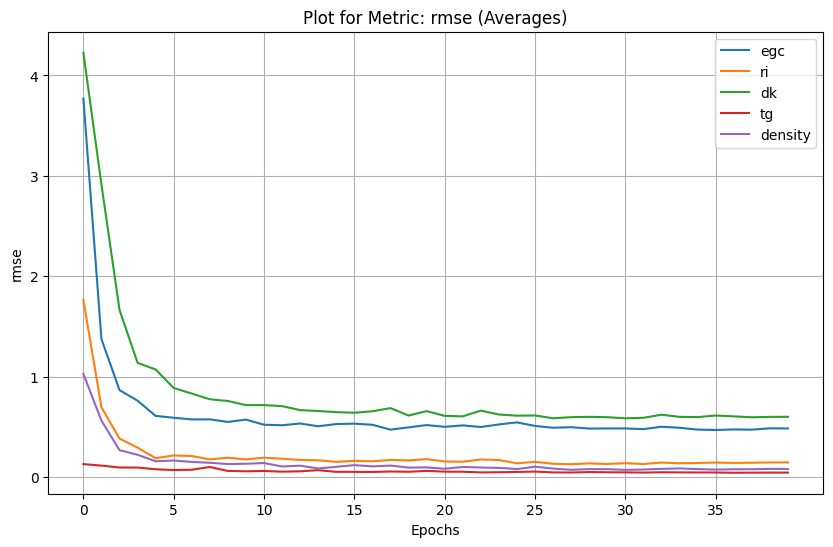

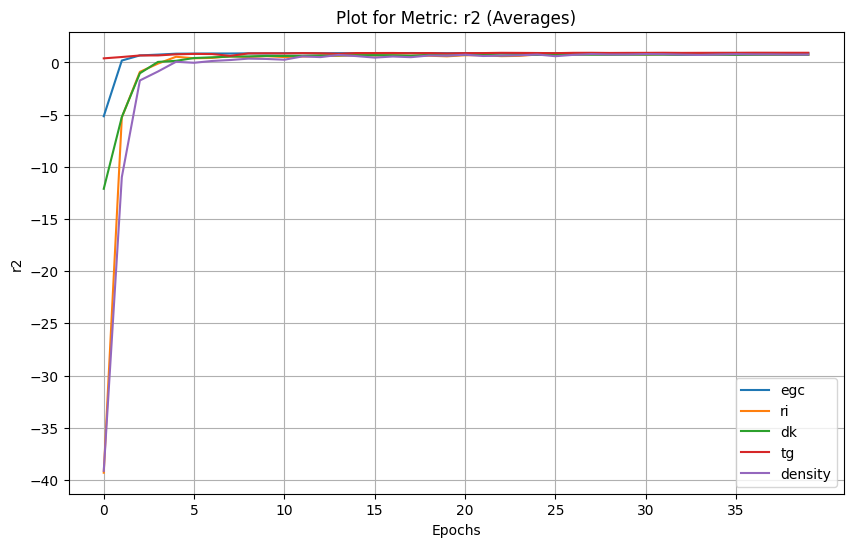

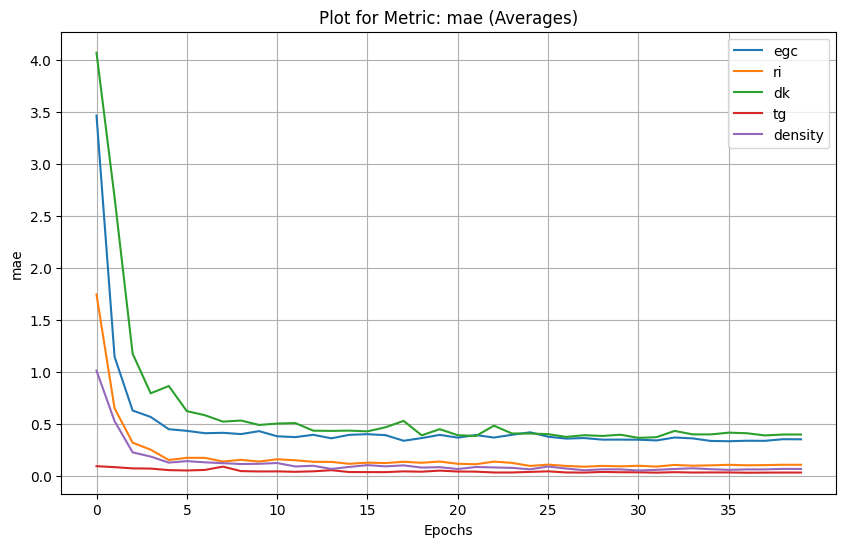

In [26]:

# Function to extract data by metric and compute averages
def extract_averages_by_metric(nested_dict):
    metrics = {}
    for task_name, records in nested_dict.items():
        for record in records:
            for metric, value in record.items():
                if metric not in metrics:
                    metrics[metric] = {}
                if task_name not in metrics[metric]:
                    metrics[metric][task_name] = []
                # Compute average if value is an array, or use the scalar value directly
                if isinstance(value, np.ndarray):
                    metrics[metric][task_name].append(value.mean())
                else:
                    metrics[metric][task_name].append(value)
    return metrics

# Extract data grouped by metric with averages
metrics_data = extract_averages_by_metric(eval_metrics)

# Plot data for each metric
for metric, tasks in metrics_data.items():
    plt.figure(figsize=(10, 6))
    for task_name, values in tasks.items():
        # Plot averages for this task
        plt.plot(range(len(values)), values, label=task_name)

    # Customize the plot
    plt.title(f"Plot for Metric: {metric} (Averages)")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    # Set x-axis ticks every 5 entries
    max_entries = max(len(values) for values in tasks.values())
    plt.xticks(ticks=range(0, max_entries, 5))

    # Show the plot
    plt.show()

In [27]:


# Compute the highest average or minimum values based on task type, including epoch
highest_scores = {}

for task_name, results in eval_metrics.items():
    if task_name in ["lipo", "delaney", "freesolv", "kiba","davis"]:  # These use 'mse'
        comparison_func = np.min
        metric_key = 'min_value'
    else:  # All other tasks use 'roc_auc'
        comparison_func = np.mean
        metric_key = 'highest_avg'
    
    best_metric = float('inf') if metric_key == 'min_value' else float('-inf')
    best_result = None
    best_epoch = None
    
    for entry_id, result in enumerate(results):
        for metric_type, values in result.items():
            values = np.array(values)  # Ensure values are NumPy arrays
            metric = comparison_func(values)  # Compute min or mean
            
            if (metric_key == 'min_value' and metric < best_metric) or \
               (metric_key == 'highest_avg' and metric > best_metric):
                best_metric = metric
                best_result = values
                best_epoch = entry_id // 11  # Calculate the epoch
    
    # Store the best metric, original values, and epoch
    highest_scores[task_name] = {
        metric_key: best_metric,
        'original_values': best_result.tolist(),  # Convert back to list for output
        'epoch': best_epoch
    }

# Output the results
for task_name, info in highest_scores.items():
    metric_key = 'min_value' if task_name in ["lipo", "delaney", "freesolv",'kiba','davis'] else 'highest_avg'
    print(f"{task_name}:")
    print(f"  {metric_key.capitalize().replace('_', ' ')}: {info[metric_key]}")
    print(f"  Original Values: {info['original_values']}")
    print(f"  Epoch: {info['epoch']}")


egc:
  Highest avg: 3.769317388534546
  Original Values: 3.769317388534546
  Epoch: 0
ri:
  Highest avg: 1.7635167837142944
  Original Values: 1.7635167837142944
  Epoch: 0
dk:
  Highest avg: 4.226528167724609
  Original Values: 4.226528167724609
  Epoch: 0
tg:
  Highest avg: 0.9318554401397705
  Original Values: 0.9318554401397705
  Epoch: 3
density:
  Highest avg: 1.0281327962875366
  Original Values: 1.0281327962875366
  Epoch: 0


In [32]:
# PRINTS ALL EPOCHS

# Function to extract data by metric and compute averages
def extract_averages_by_metric(nested_dict):
    metrics = {}
    for task_name, records in nested_dict.items():
        for record in records:
            for metric, value in record.items():
                if metric not in metrics:
                    metrics[metric] = {}
                if task_name not in metrics[metric]:
                    metrics[metric][task_name] = []
                # Compute average if value is an array, or use the scalar value directly
                if isinstance(value, np.ndarray):
                    metrics[metric][task_name].append(value.mean())
                else:
                    metrics[metric][task_name].append(value)
    return metrics

# Extract data grouped by metric with averages
metrics_data = extract_averages_by_metric(eval_metrics)

# Find best scores for each metric and task
best_scores = {}
for task_name, records in eval_metrics.items():
    for record_id, record in enumerate(records):
        for metric, value in record.items():
            if task_name not in best_scores:
                best_scores[task_name] = {}
            if metric not in best_scores[task_name]:
                best_scores[task_name][metric] = {"best_value": None, "entry_id": None}
            if isinstance(value, np.ndarray):
                score = value.mean()
            else:
                score = value
            # Update the best score if this is the highest (or lowest for MSE)
            if (
                best_scores[task_name][metric]["best_value"] is None or
                (metric == "rmse" and score < best_scores[task_name][metric]["best_value"]) or
                (metric == "mae" and score < best_scores[task_name][metric]["best_value"]) or
                (metric != "rmse" and score > best_scores[task_name][metric]["best_value"])
            ):
                best_scores[task_name][metric] = {"best_value": score, "entry_id": record_id}

# Define A4 size in inches
a4_size = ( 17.69,8.27)  # A4 in inches (width, height)

# List of colors to cycle through manually
color_list = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# Plot data for each metric and mark the best scores
for metric, tasks in metrics_data.items():
    plt.figure(figsize=a4_size)  # Set figure size to A4

    for i, (task_name, values) in enumerate(tasks.items()):
        color = color_list[i % len(color_list)]  # Cycle through the predefined colors
        # Plot averages for this task
        plt.plot(range(len(values)), values, label=f"{task_name} (avg)", color=color)

        # Overlay the best score if available
        if task_name in best_scores and metric in best_scores[task_name]:
            best_entry = best_scores[task_name][metric]
            best_value = best_entry["best_value"]
            best_id = best_entry["entry_id"]
            best_epoch = best_id  # Corrected epoch position for plotting

            # Mark the best point on the plot
            plt.scatter(best_epoch, best_value, color=color, s=100, zorder=5, label=f"{task_name} (best)")
            plt.annotate(f"Best: {best_value:.3f}", 
                         (best_epoch, best_value), 
                         textcoords="offset points", 
                         xytext=(0, 10), ha="center", color=color)

    # Customize the plot
    plt.title(f"Plot for Metric: {metric} (Averages with Best Values)")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    # Set x-axis ticks every 11 entries
    max_entries = max(len(values) for values in tasks.values())
    plt.xticks(ticks=range(0, max_entries , 5))
    # Save the plot
    filename = f"{metric}_plot_with_best_values_{notebook_name}_all_epochs.pdf"
    save_path = os.path.join("result_graphs", filename)
    plt.savefig(save_path, format="pdf", dpi=300, bbox_inches="tight")
    print(f"Plot saved as {save_path}")
    plt.close()  # Close the figure to free memory


Plot saved as result_graphs/rmse_plot_with_best_values_Stratified_CheMLT-F_RI.pdf
Plot saved as result_graphs/r2_plot_with_best_values_Stratified_CheMLT-F_RI.pdf
Plot saved as result_graphs/mae_plot_with_best_values_Stratified_CheMLT-F_RI.pdf


In [30]:
#SKIPS FIRST 5 EPOCHS
start = 5  # skip first 5 epochs from plotting

for metric, tasks in metrics_data.items():
    plt.figure(figsize=a4_size)

    for i, (task_name, values) in enumerate(tasks.items()):
        color = color_list[i % len(color_list)]

        # Plot only epochs 5..end
        epochs = list(range(start, len(values)))
        plt.plot(epochs, values[start:], label=f"{task_name} (avg)", color=color)

        # Best value marker (only show if it lies after epoch 5)
        if task_name in best_scores and metric in best_scores[task_name]:
            best_entry = best_scores[task_name][metric]
            best_value = best_entry["best_value"]
            best_id = best_entry["entry_id"]

            if best_id >= start:
                plt.scatter(best_id, best_value, color=color, s=100, zorder=5, label=f"{task_name} (best)")
                plt.annotate(
                    f"Best: {best_value:.3f}",
                    (best_id, best_value),
                    textcoords="offset points",
                    xytext=(0, 10),
                    ha="center",
                    color=color,
                )

    # Formatting
    plt.title(f"Plot for Metric: {metric} (Averages with Best Values)")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)

    # x-axis ticks start at 5
    max_entries = max(len(values) for values in tasks.values())
    plt.xticks(range(start, max_entries, 5))

    filename = f"{metric}_plot_with_best_values_{notebook_name}_ALL.pdf"
    save_path = os.path.join("result_graphs", filename)
    plt.savefig(save_path, format="pdf", dpi=300, bbox_inches="tight")
    print(f"Plot saved as {save_path}")
    plt.close()

Plot saved as result_graphs/rmse_plot_with_best_values_Stratified_CheMLT-F_ALL.pdf
Plot saved as result_graphs/r2_plot_with_best_values_Stratified_CheMLT-F_ALL.pdf
Plot saved as result_graphs/mae_plot_with_best_values_Stratified_CheMLT-F_ALL.pdf


In [31]:
from IPython.display import display

# Build a simple, clean table of best metrics
rows = []

for task_name, metrics in best_scores.items():
    best_rmse_info = metrics.get("rmse", {})
    best_r2_info   = metrics.get("r2", {})
    best_mae_info   = metrics.get("mae", {})

    rows.append({
        "task": task_name,
        "best_rmse": best_rmse_info.get("best_value", None),
        "rmse_entry": best_rmse_info.get("entry_id", None),
        "best_r2": best_r2_info.get("best_value", None),
        "r2_entry": best_r2_info.get("entry_id", None),
        "best_mae": best_mae_info.get("best_value", None),
        "mae_entry": best_mae_info.get("entry_id", None),
    })

best_table = pd.DataFrame(rows).set_index("task")

print("=== BEST METRICS PER TASK ===")
display(best_table)

# GLOBAL BESTS (across all tasks)
try:
    best_global_r2_value = best_table["best_r2"].max()
    best_global_r2_task  = best_table["best_r2"].idxmax()
except:
    best_global_r2_value = None
    best_global_r2_task = None

try:
    best_global_rmse_value = best_table["best_rmse"].min()
    best_global_rmse_task  = best_table["best_rmse"].idxmin()
except:
    best_global_rmse_value = None
    best_global_rmse_task = None

try:
    best_global_mae_value = best_table["best_mae"].min()
    best_global_mae_task  = best_table["best_mae"].idxmin()
except:
    best_global_mae_value = None
    best_global_mae_task = None

print("\n=== GLOBAL BESTS ===")
print(f"Best R²  = {best_global_r2_value:.6f}  (task: {best_global_r2_task})" if best_global_r2_value is not None else "No R² values found.")
print(f"Best RMSE = {best_global_rmse_value:.6f}  (task: {best_global_rmse_task})" if best_global_rmse_value is not None else "No RMSE values found.")
print(f"Best MAE = {best_global_mae_value:.6f}  (task: {best_global_mae_task})" if best_global_mae_value is not None else "No MAE values found.")

=== BEST METRICS PER TASK ===


,best_rmse,rmse_entry,best_r2,r2_entry,best_mae,mae_entry
task,,,,,,
egc,0.468809,35,0.904762,35,0.351562,39
ri,0.127530,27,0.789190,27,0.106401,39
dk,0.585005,30,0.748933,30,0.397756,39
tg,0.043037,36,0.931855,36,0.031768,39
density,0.071858,30,0.803940,30,0.066192,39



=== GLOBAL BESTS ===
Best R²  = 0.931855  (task: tg)
Best RMSE = 0.043037  (task: tg)
Best MAE = 0.031768  (task: tg)


In [32]:
metrics_data

{'rmse': {'egc': [3.769317388534546,
   1.3743717670440674,
   0.8660140633583069,
   0.7603558301925659,
   0.6092695593833923,
   0.5903691053390503,
   0.5741738080978394,
   0.57447749376297,
   0.5488711595535278,
   0.572256326675415,
   0.5210484266281128,
   0.5158297419548035,
   0.5334661602973938,
   0.5058671236038208,
   0.5277434587478638,
   0.5315946340560913,
   0.5207763314247131,
   0.4719292223453522,
   0.4947376549243927,
   0.5175049901008606,
   0.5001763701438904,
   0.5145079493522644,
   0.49830809235572815,
   0.5239709615707397,
   0.544345498085022,
   0.5089614391326904,
   0.49103257060050964,
   0.49650487303733826,
   0.48281627893447876,
   0.4839506149291992,
   0.48378708958625793,
   0.47734835743904114,
   0.5008599758148193,
   0.49084705114364624,
   0.47251737117767334,
   0.46880903840065,
   0.47388094663619995,
   0.47208601236343384,
   0.48512792587280273,
   0.48413383960723877],
  'ri': [1.7635167837142944,
   0.6954025030136108,
   0.38

In [33]:

# Define save directory
save_dir = "my_trained_model_"+notebook_name
os.makedirs(save_dir, exist_ok=True)

# Save model weights and config
trainer.model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)  # If using a tokenizer

print(f"Model saved to {save_dir}")

Model saved to my_trained_model_Stratified_CheMLT-F


In [34]:
torch.save({
    "step": 20,
    "optimizer": optimizer.state_dict()
}, os.path.join(save_dir, "optimizer_state.pt"))

#torch.save(optimizer_state, os.path.join(save_dir, "optimizer_state.pt"))

print("Optimizer state saved.")

Optimizer state saved.
